In [14]:
# download_data.py

import pandas as pd
import requests
import zipfile
import tarfile
import io

url = "https://archive.ics.uci.edu/static/public/401/gene+expression+cancer+rna+seq.zip"

print("📥 Downloading dataset...")
response = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(response.content))

print("Files in ZIP:", z.namelist())

# Extract the tar.gz file into memory
tar_gz_filename = None
for f in z.namelist():
    if f.endswith(".tar.gz"):
        tar_gz_filename = f
        break

if tar_gz_filename is None:
    raise FileNotFoundError("No tar.gz file found in the ZIP archive.")

print(f"Extracting {tar_gz_filename} from ZIP and reading...")

# Extract tar.gz file bytes
tar_gz_bytes = z.read(tar_gz_filename)

# Open tar.gz from bytes
tar_file = tarfile.open(fileobj=io.BytesIO(tar_gz_bytes), mode="r:gz")

# List files inside tar.gz
print("Files in tar.gz:", tar_file.getnames())

# Look for CSV inside tar.gz
csv_filename = None
for f in tar_file.getnames():
    if f.endswith(".csv"):
        csv_filename = f
        break

if csv_filename is None:
    raise FileNotFoundError("No CSV file found inside the tar.gz archive.")

print(f"Reading CSV file: {csv_filename}")

# Extract CSV file
csv_file = tar_file.extractfile(csv_filename)
df = pd.read_csv(csv_file)

# Rename last column to 'label'
df.rename(columns={df.columns[-1]: 'label'}, inplace=True)

# Save to CSV
df.to_csv("gene_expression_cancer.csv", index=False)
print("✅ Saved gene_expression_cancer.csv with shape:", df.shape)


📥 Downloading dataset...
Files in ZIP: ['TCGA-PANCAN-HiSeq-801x20531.tar.gz']
Extracting TCGA-PANCAN-HiSeq-801x20531.tar.gz from ZIP and reading...
Files in tar.gz: ['TCGA-PANCAN-HiSeq-801x20531', 'TCGA-PANCAN-HiSeq-801x20531/data.csv', 'TCGA-PANCAN-HiSeq-801x20531/labels.csv']
Reading CSV file: TCGA-PANCAN-HiSeq-801x20531/data.csv
✅ Saved gene_expression_cancer.csv with shape: (801, 20532)



=== Fold 1 ===
Selected 20530 features out of 20530
Best hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 100}
Fold 1 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       141

    accuracy                           1.00       141
   macro avg       1.00      1.00      1.00       141
weighted avg       1.00      1.00      1.00       141



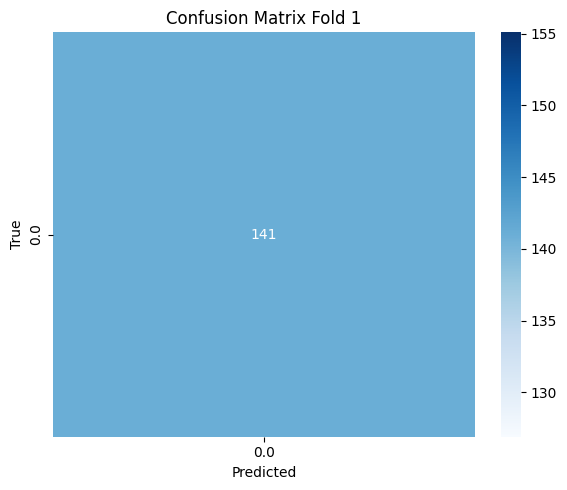


=== Fold 2 ===
Selected 20530 features out of 20530
Best hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 100}
Fold 2 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       141

    accuracy                           1.00       141
   macro avg       1.00      1.00      1.00       141
weighted avg       1.00      1.00      1.00       141



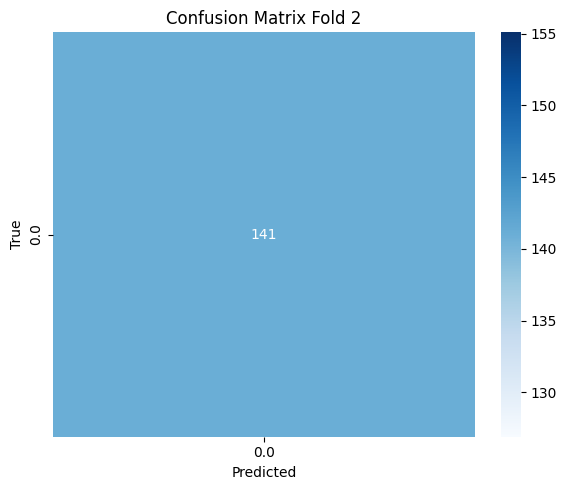


=== Fold 3 ===
Selected 20530 features out of 20530
Best hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 100}
Fold 3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       141

    accuracy                           1.00       141
   macro avg       1.00      1.00      1.00       141
weighted avg       1.00      1.00      1.00       141



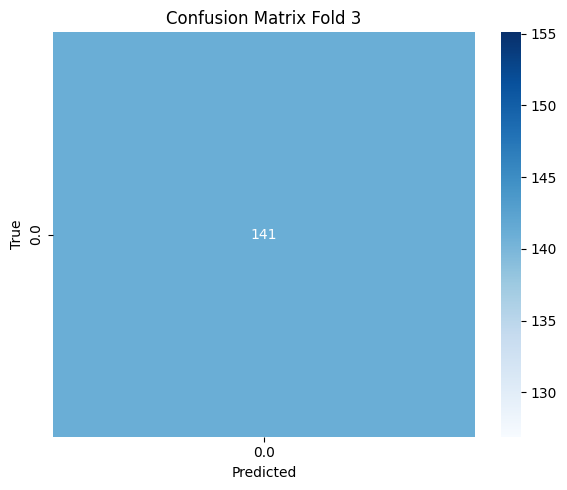


=== Fold 4 ===
Selected 20530 features out of 20530
Best hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 100}
Fold 4 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       140

    accuracy                           1.00       140
   macro avg       1.00      1.00      1.00       140
weighted avg       1.00      1.00      1.00       140



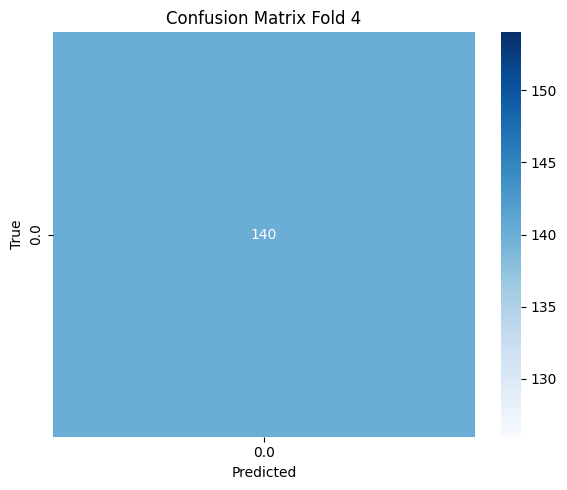


=== Fold 5 ===
Selected 20530 features out of 20530
Best hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 100}
Fold 5 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       140

    accuracy                           1.00       140
   macro avg       1.00      1.00      1.00       140
weighted avg       1.00      1.00      1.00       140



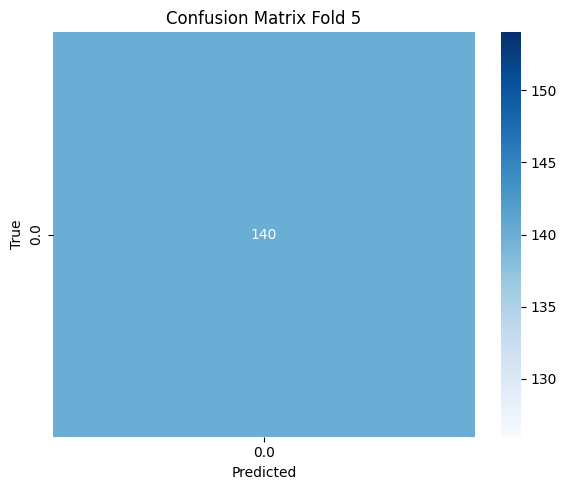


Average Accuracy over 5 folds: 1.0000
Standard Deviation of Accuracy: 0.0000


In [19]:
# cancer_gene_classifier_cv_advanced.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Load dataset
df = pd.read_csv("gene_expression_cancer.csv")
df = df.dropna()

# Filter classes with at least 2 samples
counts = df['label'].value_counts()
valid_classes = counts[counts >= 2].index
df = df[df['label'].isin(valid_classes)]

# Remove non-numeric columns except 'label'
non_numeric_cols = df.select_dtypes(include=['object']).columns.tolist()
if 'label' in non_numeric_cols:
    non_numeric_cols.remove('label')

X_full = df.drop(columns=non_numeric_cols + ['label'])
y = df['label']

# Normalize features
scaler = StandardScaler()
X_scaled_full = scaler.fit_transform(X_full)

# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
fold = 1

for train_index, test_index in skf.split(X_scaled_full, y):
    print(f"\n=== Fold {fold} ===")
    X_train_full, X_test_full = X_scaled_full[train_index], X_scaled_full[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Step 1: Feature selection with RandomForest on training fold only
    fs_model = RandomForestClassifier(n_estimators=100, random_state=42)
    fs_model.fit(X_train_full, y_train)

    selector = SelectFromModel(fs_model, prefit=True, threshold='median')  # Select features above median importance
    X_train = selector.transform(X_train_full)
    X_test = selector.transform(X_test_full)

    print(f"Selected {X_train.shape[1]} features out of {X_train_full.shape[1]}")

    # Step 2: Hyperparameter tuning with GridSearchCV on training fold
    rf = RandomForestClassifier(random_state=42)

    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 15, 20],
        'min_samples_leaf': [2, 5, 10],
        'max_features': ['sqrt', 0.3, 0.5]
    }

    grid_search = GridSearchCV(
        rf, param_grid, cv=3, n_jobs=-1, scoring='accuracy', verbose=0
    )
    grid_search.fit(X_train, y_train)
    best_rf = grid_search.best_estimator_

    print("Best hyperparameters:", grid_search.best_params_)

    # Step 3: Evaluate best model on test fold
    y_pred = best_rf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

    print(f"Fold {fold} Accuracy: {acc:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Confusion matrix plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=best_rf.classes_, yticklabels=best_rf.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix Fold {fold}")
    plt.tight_layout()
    plt.show()

    fold += 1

print(f"\nAverage Accuracy over {skf.get_n_splits()} folds: {np.mean(accuracies):.4f}")
print(f"Standard Deviation of Accuracy: {np.std(accuracies):.4f}")
